In [34]:
# Author : Evangelos Papoutsellis
# Contact : http://epapoutsellis.github.io/

## Stochastic hackathon progress (Summary)

- Continues work from [Paper-2021-RSTA-CIL-Part-I](https://github.com/TomographicImaging/Paper-2021-RSTA-CIL-Part-I/blob/main/case03_PET.ipynb)

- Requires [subset_object](https://github.com/SyneRBI/SIRF/tree/subset_object) from SIRF and
```pet.AcquisitionData.set_storage_scheme("memory")```
- It uses the new functionality of KullbackLeibler function class. [WIP](https://github.com/TomographicImaging/CIL/pull/1272).
- Compares 2 different acquisition models: RayTracing vs ParallelProj using the full dataset and with subsets.
- NEMA dataset is used.
- Check FISTA algorithm RayTracing/ParalleProj full dataset and subsets
- SPHDG algorithm: KL + FGP_TV. Different regularisation parameter is used compared to [Paper-2021-RSTA-CIL-Part-I](https://github.com/TomographicImaging/Paper-2021-RSTA-CIL-Part-I/blob/main/case03_PET.ipynb) put a different SIRF operator is used, i.e., ParallelProj
 

### Need to add path for the [`lib`](https://github.com/SyneRBI/SIRF-Exercises/tree/master/lib/sirf_exercises) directory

In [2]:
import sys
sys.path.insert(1, '../../../../lib')

import notebook_setup
from sirf_exercises import cd_to_working_dir
cd_to_working_dir('PET', 'reconstruct_measured_data')

In [3]:
#Initial imports etc
import numpy
import matplotlib.pyplot as plt

import os
import sys
import shutil
import sirf

import sirf.STIR as pet
from sirf.Utilities import examples_data_path
from sirf_exercises import exercises_data_path
from cil.utilities.display import show2D

# cil imports
from cil.plugins.ccpi_regularisation.functions import FGP_TV    
from cil.optimisation.functions import KullbackLeibler, IndicatorBox, BlockFunction, OperatorCompositionFunction
from cil.optimisation.algorithms import SPDHG, PDHG, FISTA   
from cil.optimisation.operators import BlockOperator

# turn off verbosity
pet.set_verbosity(0)
pet.AcquisitionData.set_storage_scheme("memory")
msg = sirf.STIR.MessageRedirector(info=None, warn=None, errr=None)

# problem with "check input method" `geometry` attribute does not exist in SIRF
def new_check_input(self, input):
    pass

FGP_TV.check_input = new_check_input


### Load NEMA dataset

In [4]:
# Change to the data directory
data_path = exercises_data_path('PET', 'mMR', 'NEMA_IQ')

In [5]:
#%% set filenames 
# input files
list_file = os.path.join(data_path, '20170809_NEMA_60min_UCL.l.hdr')
norm_file = 'norm.n.hdr'
attn_file = 'umap.v.hdr'
sino_file = 'sino'

In [6]:
# redirect STIR messages to some files
# you can check these if things go wrong
msg_red = sirf.STIR.MessageRedirector('info.txt', 'warn.txt')

In [7]:
template_acq_data = pet.AcquisitionData('Siemens_mMR', span=11, max_ring_diff=15, view_mash_factor=1)
template_acq_data.write('template.hs')
# create listmode-to-sinograms converter object
lm2sino = pet.ListmodeToSinograms()

# set input, output and template files
lm2sino.set_input(list_file)
lm2sino.set_output_prefix(sino_file)
lm2sino.set_template('template.hs')
# set timing interval (in secs) since start of acquisition
# (the listmode file provided is for 1 hour).
# you can vary this to see the effect on noise. Increasing it will mean somewhat longer
# processing time in the following steps (but not in the reconstruction).
lm2sino.set_time_interval(0, 500)
# set up the converter
lm2sino.set_up()
# create the prompts sinogram
lm2sino.process()
# get access to the sinograms
# acq_data = lm2sino.get_output()
acq_data = pet.AcquisitionData('sino_f1g1d0b0.hs')


This is fine, but note that in previous versions of STIR this last segment was dropped.



Processing time frame 1



INFO: CListModeDataECAT8_32bit: opening file /home/vaggelis/SIRF_subsets/SIRF-Exercises/data/PET/mMR/NEMA_IQ/20170809_NEMA_60min_UCL.l
13000000 events stored


Number of prompts stored in this time period : 13043732
Number of delayeds stored in this time period: 0
Last stored event was recorded before time-tick at 500 secs
Total number of counts (either prompts/trues/delayeds) stored: 13043732

This took 15.27s CPU time.


In [8]:
# random
rand = lm2sino.estimate_randoms()
rand.write('sino_randoms_f1g1d0b0')

# attenuation
attns = pet.ImageData(attn_file)
asm_norm = pet.AcquisitionSensitivityModel(norm_file)

estimate_randoms: trying GEHDF5...
not a GE HDF5 file. Using ML estimate from delayeds
processed frame 1
Starting iteration 1	KL 1941.92
Starting iteration 2	KL 142.99
Starting iteration 3	KL 5.14518
Starting iteration 4	KL 0.218351
Starting iteration 5	KL 0.00904963
Starting iteration 6	KL 0.000365185
Starting iteration 7	KL 1.62128e-05
Starting iteration 8	KL 3.8093e-07
Starting iteration 9	KL 8.08076e-09
Starting iteration 10	KL 1.15392e-09
CPU time 68.43 secs


Last stored event was recorded after time-tick at 499.999 secs
Total number of prompts/trues/delayed stored: 3506594

Reading manufacturer PET normalisation file from norm.n.hdr




This took 7.63s CPU time.






















































































In [9]:
def get_asm_attn(sino, attn, acq_model):
    """Get attn Attenuation Sensitivity Model from sino, attn image and acq model."""
    asm_attn = pet.AcquisitionSensitivityModel(attn, acq_model)
    # temporary fix pending attenuation offset fix in STIR:
    # converting attenuation into 'bin efficiency'
    asm_attn.set_up(sino)
    bin_eff = pet.AcquisitionData(sino)
    bin_eff.fill(1.0)
    asm_attn.unnormalise(bin_eff)
    asm_attn = pet.AcquisitionSensitivityModel(bin_eff)
    return asm_attn


def select_acq_model(backend, num_subsets = 1, background=True):
    
    if backend == "RayTracing":
        am = pet.AcquisitionModelUsingRayTracingMatrix()
    elif backend == "ParallelProj":
        am = pet.AcquisitionModelUsingParallelproj()
    else:
        raise NotImplemented
        
    if num_subsets>1:
        list_am = []
        list_objectives = []
        
    # shape of acq_data
    dim = acq_data.shape
        
    if num_subsets == 1:
        
        # ASM norm already there
        asm_attn = get_asm_attn(acq_data, attns, am)        
        
        # Get ASM dependent on attn and/or norm
        asm = pet.AcquisitionSensitivityModel(asm_norm, asm_attn)
        am.set_acquisition_sensitivity(asm)
        am.set_background_term(rand)
        am.set_up(acq_data, image) 
        
        return am   
    
    else:
        
        for i in range(num_subsets):
            
            views = numpy.arange(i, dim[2], num_subsets)

            data_subset = acq_data.get_subset(views)
            # print(views,'\n', data_subset.shape)
            
            asm_attn = get_asm_attn(data_subset, attns, am)             
            am.set_acquisition_sensitivity(asm_attn)
            
            if background:
                am.set_background_term(rand.get_subset(views))
            am.set_up(data_subset,image) 
            
            list_am.append(am)
            
        return list_am
        
# Setup image geometry
image = acq_data.create_uniform_image(0., (127, 220, 220))
image.initialise(dim=(127, 220, 220), vsize=(2.03125, 1.7080754, 1.7080754))


### RayTracing vs ParallelProj (Full data)

In [10]:
am_ray_tracing = select_acq_model("RayTracing")  
am_parallel_proj = select_acq_model("ParallelProj")  

### Adjoint operation

In [11]:
%timeit -r 3 am_ray_tracing.adjoint(acq_data)

9.1 s ± 74.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [12]:
%timeit -r 3 am_parallel_proj.adjoint(acq_data)

4.45 s ± 201 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


### Direct operation

In [13]:
%timeit -r 3 am_ray_tracing.get_linear_acquisition_model().direct(image)

20.2 s ± 181 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [14]:
%timeit -r 3 am_parallel_proj.get_linear_acquisition_model().direct(image)

3.61 s ± 34.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


### RayTracing vs ParallelProj (Subsets data)

In [15]:
num_subsets = 28

In [16]:
am_ray_tracing_subsets =  select_acq_model("RayTracing", num_subsets = num_subsets)  
am_parallel_proj_subsets =  select_acq_model("ParallelProj", num_subsets = num_subsets)  

### Time for only one subset

In [17]:
%timeit -r 3 am_ray_tracing_subsets[0].get_linear_acquisition_model().direct(image)

866 ms ± 34.9 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [18]:
%timeit -r 3 am_parallel_proj_subsets[0].get_linear_acquisition_model().direct(image)

102 ms ± 6.14 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [19]:
tmp_sino = am_ray_tracing_subsets[0].get_linear_acquisition_model().direct(image)

In [20]:
%timeit -r 3 am_ray_tracing_subsets[0].get_linear_acquisition_model().adjoint(tmp_sino)

737 ms ± 113 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [21]:
%timeit -r 3 am_parallel_proj_subsets[0].get_linear_acquisition_model().adjoint(tmp_sino)

587 ms ± 33.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


### OSMAPOSLReconstructor (RayTracing vs ParallelProj)

In [22]:
def osem_recon(model, num_subsets = 7, num_subiterations = 58):
    
    obj_fun = pet.make_Poisson_loglikelihood(acq_data)
    obj_fun.set_acquisition_model(model)

    recon = pet.OSMAPOSLReconstructor()
    recon.set_objective_function(obj_fun)

    recon.set_num_subsets(num_subsets)
    recon.set_num_subiterations(num_subiterations)

    recon.set_up(image)
    # set the initial image estimate
    recon.set_current_estimate(image)
    # reconstruct
    recon.process()
    
    return recon.get_output().as_array()
    
print(" OSMAPOSLReconstructor with RayTracing ") 
recon_ray_tracing =  osem_recon(am_ray_tracing)   

print(" OSMAPOSLReconstructor with Parallel Proj ") 
recon_parallelproj =  osem_recon(am_parallel_proj)   

 OSMAPOSLReconstructor with RayTracing 
trying GEHDF5...
not a GE HDF5 file


Total CPU Time 3877.26secs


 OSMAPOSLReconstructor with Parallel Proj 


Total CPU Time 238.77secs


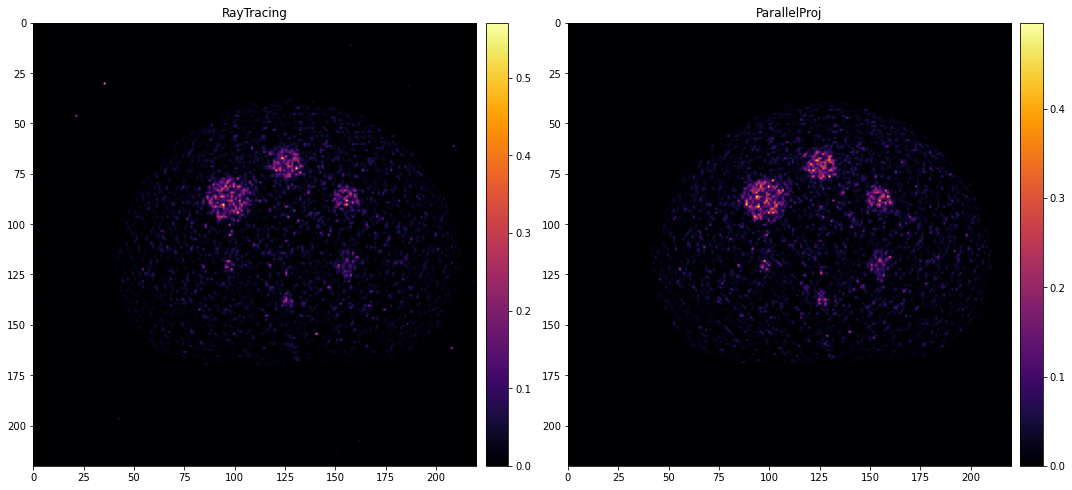

In [23]:
show2D([recon_ray_tracing[72], recon_parallelproj[72]], 
       title=["RayTracing", "ParallelProj"], 
       origin="upper", cmap = "inferno")

### Solve with FISTA (use of gradient of KullbackLeibler, full data)

- `am_ray_tracing.get_linear_acquisition_model().norm()` = 1099.076416015625
- `am_parallel_proj.get_linear_acquisition_model().norm()` =  1101.6077880859375

In [24]:
# Solve with FISTA
initial = image

alpha = 0.1
G1 = IndicatorBox(lower=0)

F = KullbackLeibler(b = acq_data, eta = rand, backend="numpy") # numba gets zero division error 
# https://github.com/TomographicImaging/CIL/issues/1312

F.L = 0.001 # that's a guess


In [25]:
# ray tracing
K_ray_tracing = am_ray_tracing.get_linear_acquisition_model()
F_fista_ray_tracing = OperatorCompositionFunction(F, K_ray_tracing)

fista1 = FISTA(initial = initial, f = F_fista_ray_tracing, g=G1, update_objective_interval=1,
                            max_iteration=10)
fista1.run(2, verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0         10         0.000          3.27454e+07
        1         10        47.689          3.60038e+10
        2         10        47.604          3.06581e+10
-------------------------------------------------------
        2         10        47.604          3.06581e+10
Stop criterion has been reached.



In [26]:
# parallel proj
K_parallel_proj = am_parallel_proj.get_linear_acquisition_model()
F_fista_parallel_proj = OperatorCompositionFunction(F, K_parallel_proj)

fista2 = FISTA(initial = initial, f = F_fista_parallel_proj, g=G1, update_objective_interval=1,
                            max_iteration=10)
fista2.run(2, verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0         10         0.000          3.27475e+07
        1         10        13.995          3.44574e+10
        2         10        14.088          2.88818e+10
-------------------------------------------------------
        2         10        14.088          2.88818e+10
Stop criterion has been reached.



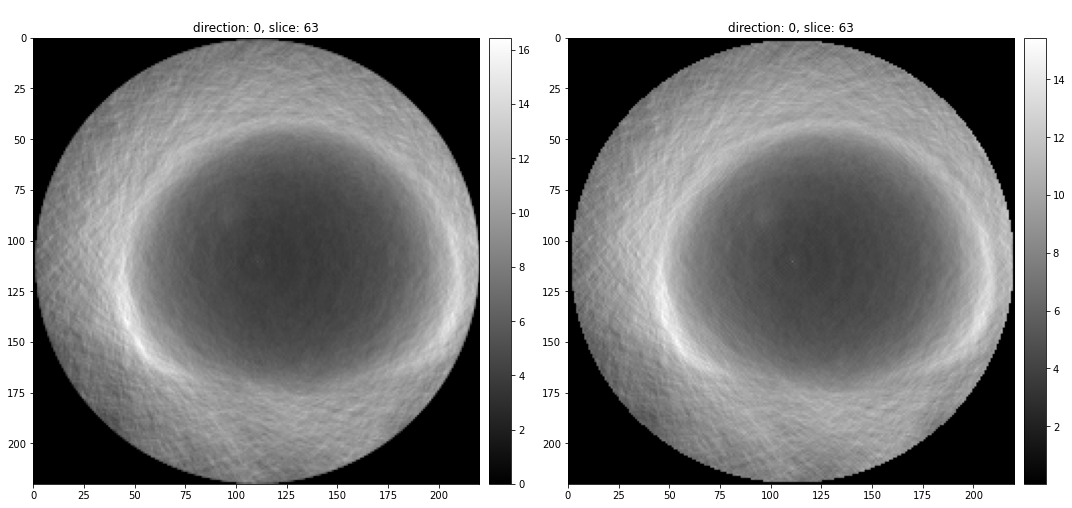

In [27]:
show2D([fista1.solution.as_array(), fista2.solution.as_array()], origin="upper")

### Solve with SPDHG (use of proximal conjugate of KullbackLeibler and the subsets functionality of SIRF)

In [28]:
# repeated code 

num_subsets = 9

dim = acq_data.dimensions()
print('data dimensions: %d x %d x %d x %d' % dim) 

f_subsets = []
A_subsets = []

for i in range(num_subsets):
    
    views = numpy.arange(i, dim[2], num_subsets)
    
    data_subset = acq_data.get_subset(views)
    print(views,'\n', data_subset.shape, len(views))
    eta_sirf = rand.get_subset(views)
    
    fi = KullbackLeibler(b = data_subset, eta = eta_sirf, backend = "numba") 
    f_subsets.append(fi)    
    
    # acq_model = pet.AcquisitionModelUsingRayTracingMatrix()
    acq_model = pet.AcquisitionModelUsingParallelproj()
    asm_attn = get_asm_attn(data_subset, attns, acq_model)  
    acq_model.set_acquisition_sensitivity(asm_attn)
    acq_model.set_up(data_subset,image)  
                
    A_subsets.append(acq_model)
        
# Define F and K
F = BlockFunction(*f_subsets)
K = BlockOperator(*A_subsets)

data dimensions: 1 x 357 x 252 x 344
[  0   9  18  27  36  45  54  63  72  81  90  99 108 117 126 135 144 153
 162 171 180 189 198 207 216 225 234 243] 
 (1, 357, 28, 344) 28
[  1  10  19  28  37  46  55  64  73  82  91 100 109 118 127 136 145 154
 163 172 181 190 199 208 217 226 235 244] 
 (1, 357, 28, 344) 28
[  2  11  20  29  38  47  56  65  74  83  92 101 110 119 128 137 146 155
 164 173 182 191 200 209 218 227 236 245] 
 (1, 357, 28, 344) 28
[  3  12  21  30  39  48  57  66  75  84  93 102 111 120 129 138 147 156
 165 174 183 192 201 210 219 228 237 246] 
 (1, 357, 28, 344) 28
[  4  13  22  31  40  49  58  67  76  85  94 103 112 121 130 139 148 157
 166 175 184 193 202 211 220 229 238 247] 
 (1, 357, 28, 344) 28
[  5  14  23  32  41  50  59  68  77  86  95 104 113 122 131 140 149 158
 167 176 185 194 203 212 221 230 239 248] 
 (1, 357, 28, 344) 28
[  6  15  24  33  42  51  60  69  78  87  96 105 114 123 132 141 150 159
 168 177 186 195 204 213 222 231 240 249] 
 (1, 357, 28, 344) 

**No need to compute the norms for each subset operator**
- `K[0].norm()` = 86.88260650634766 , num_subsets = 9

In [29]:
norm_am_parallel_proj = [86.89]*num_subsets

In [32]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

alpha = 2.0
G1 = alpha * FGP_TV(max_iteration=100, device='gpu' )

# Setup and run SPDHG (ray tracing )
spdhg = SPDHG(f = F, g = G1, operator = K, max_iteration = num_subsets*100,
            update_objective_interval = num_subsets*5, norms = norm_am_parallel_proj)
spdhg.run(verbose = 2)


INFO:root:SPDHG setting up
INFO:root:SPDHG configured


     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        900         0.000    3.27847e+07  -0.00000e+00    3.27847e+07
       45        900         5.125    1.18112e+07   9.68271e+05    1.08429e+07
       90        900         5.194    1.16648e+07   1.48755e+06    1.01772e+07
      135        900         5.181    1.18058e+07   2.09359e+06    9.71224e+06
      180        900         5.176    1.15987e+07   2.65314e+06    8.94556e+06
      225        900         5.169    1.15672e+07   3.13447e+06    8.43273e+06
      270        900         5.166    1.16383e+07   3.56371e+06    8.07464e+06
      315        900         5.169    1.17197e+07   3.96082e+06    7.75889e+06
      360        900         5.183    1.17649e+07   4.33776e+06    7.42716e+06
      405        900         5.180    1.18657e+07   4.66928e+06    7.19640e+06
      450        900         5.196    1.18903e+07   

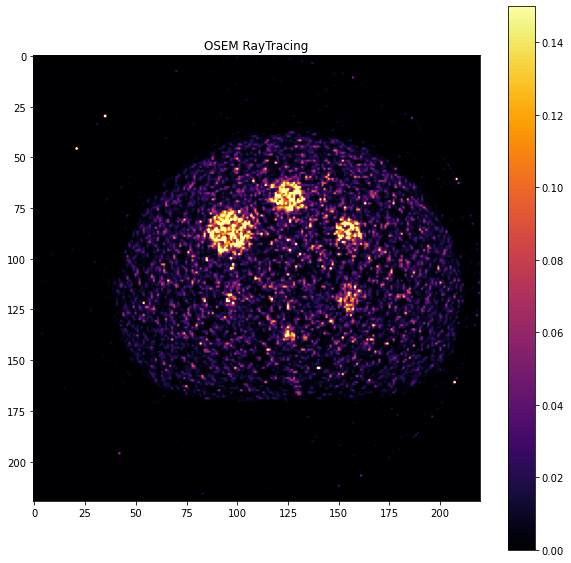

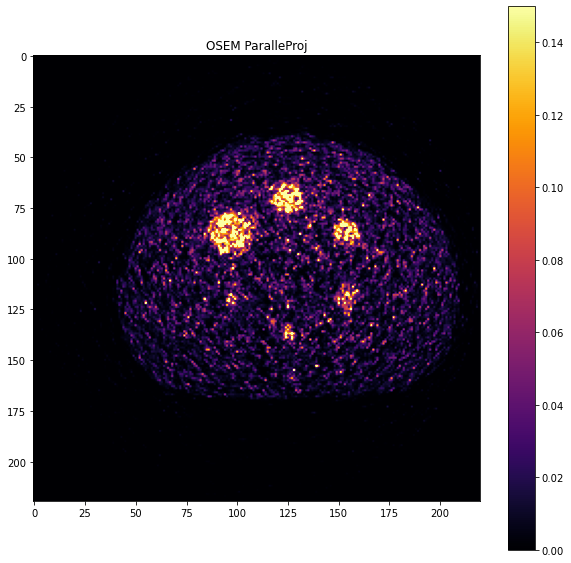

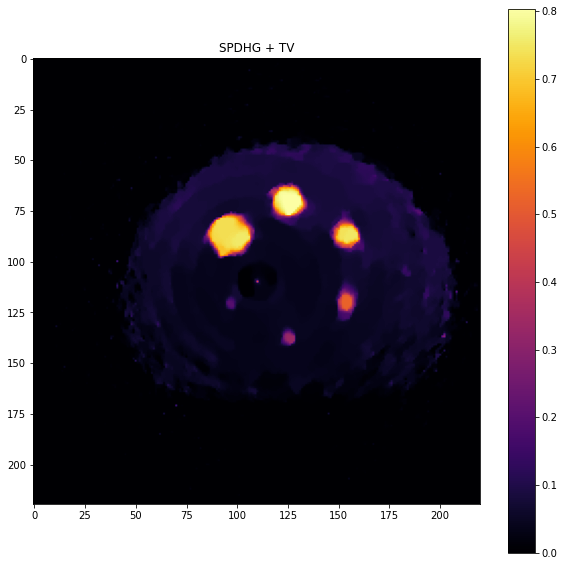

In [33]:
ss = 72

plt.figure(figsize=(10,10))
plt.imshow(recon_ray_tracing[72], cmap="inferno", vmax = 0.15)
plt.title("OSEM RayTracing")
plt.colorbar()
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(recon_parallelproj[72], cmap="inferno", vmax = 0.15)
plt.title("OSEM ParalleProj")
plt.colorbar()
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(spdhg.solution.as_array()[72], cmap="inferno")
plt.title("SPDHG + TV")
plt.colorbar()
plt.show()